## ¿Es posible, que mediante una aplicacion de machine learning, podamos clasificar las radigrafias segun ciertas enfermedades?
## Se han recolectado diversas imagenes de Rx De torax, junto con las enfermedades detectadas por médicos reales

#### Ahora el reto es agilizar la detección de problemas en menor tiempo al habitual, y ayude de cierta forma al médico.

#### se disponen de las siguientes imagenes:
#### 133 Sanos
#### 133 Covid
#### 133 Pneumonia Bacteriana
#### 133 Pneumonia Vírica

In [18]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers,  optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input,Add,Dense,Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
url = "C:\\Users\\wongp\\Udemy\\Data Science Aplicada\\Operaciones\\4. Operations Department\\Dataset"

In [3]:
os.listdir(url)

['0', '1', '2', '3']

In [4]:
image_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [5]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = url, shuffle=True, target_size = (256,256), class_mode="categorical",subset="training")
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = url, shuffle=True, target_size = (256,256), class_mode="categorical",subset="validation") 

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [6]:
train_images, train_labels = next(train_generator)

In [7]:
train_images.shape

(40, 256, 256, 3)

In [8]:
train_labels.shape

(40, 4)

In [9]:
labels_names ={0:"covid",1:"sano",2:"pneumonia virica",3:"pneumonia bacteriana"}

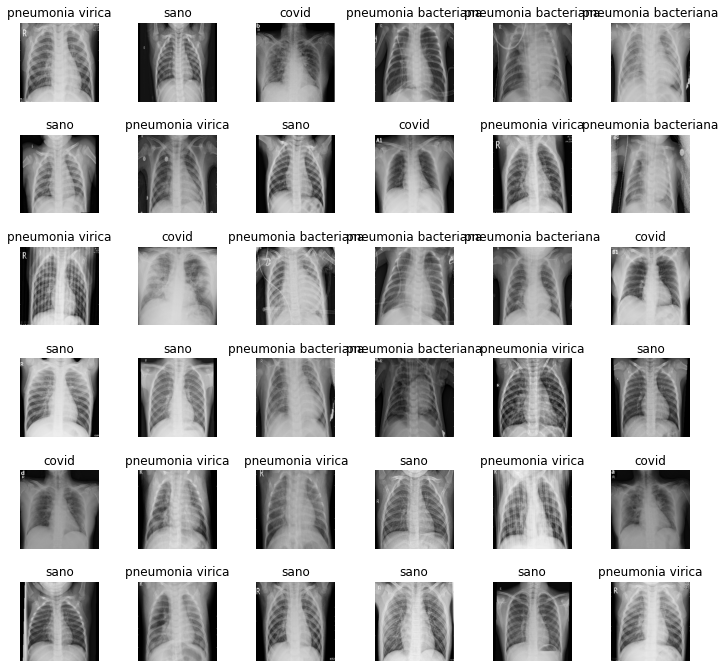

In [10]:
L = 6
W = 6
fig, axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels_names[np.argmax(train_labels[i])])
    axes[i].axis("off")
    
plt.subplots_adjust(wspace = 0.5)

In [12]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor=Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 15s 0us/step


In [14]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
for layer in basemodel.layers[:-10]:
    layer.trainable = False
    

In [19]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = "softmax")(headmodel)
model = Model(inputs=basemodel.input,outputs = headmodel)

In [21]:
model.compile(loss="categorical_crossentropy", optimizer = optimizers.RMSprop(learning_rate=1e-4, decay=1e-6),metrics = ["accuracy"])

In [22]:
earlystopping = EarlyStopping(monitor = "val_loss",mode = "min", verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [23]:
train_generator = image_generator.flow_from_directory(batch_size=4,directory=url,shuffle=True, target_size=(256,256),class_mode="categorical", subset="training")
val_generator = image_generator.flow_from_directory(batch_size=4,directory=url,shuffle=True, target_size=(256,256),class_mode="categorical", subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [29]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n//4,epochs=25,
                             validation_data = val_generator, validation_steps = val_generator.n //4,
                             callbacks = [checkpointer,earlystopping])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.8014
Epoch 1: val_loss did not improve from 0.68228
107/107 [==============================] - 54s 505ms/step - loss: 0.5553 - accuracy: 0.8014 - val_loss: 1.0096 - val_accuracy: 0.7019
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8061
Epoch 2: val_loss did not improve from 0.68228
107/107 [==============================] - 57s 535ms/step - loss: 0.5399 - accuracy: 0.8061 - val_loss: 2.8197 - val_accuracy: 0.5288
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8551
Epoch 3: val_loss improved from 0.68228 to 0.55394, saving model to weights.hdf5
107/107 [==============================] - 57s 535ms/step - loss: 0.5184 - accuracy: 0.8551 - val_loss: 0.5539 - val_accuracy: 0.8173
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8458
Epoch 4: val_loss did not improve from 

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

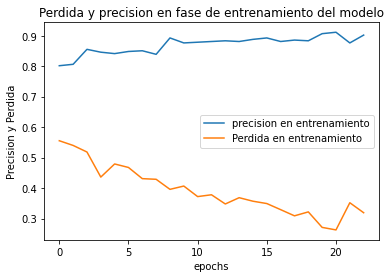

In [33]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Perdida y precision en fase de entrenamiento del modelo")
plt.ylabel("Precision y Perdida")
plt.xlabel("epochs")
plt.legend(["precision en entrenamiento","Perdida en entrenamiento"])

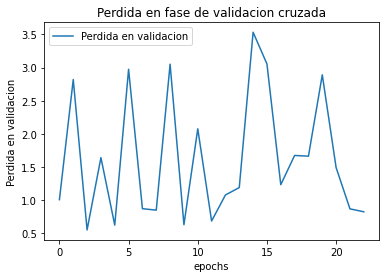

In [34]:
plt.plot(history.history["val_loss"])

plt.title("Perdida en fase de validacion cruzada")
plt.ylabel("Perdida en validacion")
plt.xlabel("epochs")
plt.legend(["Perdida en validacion"])

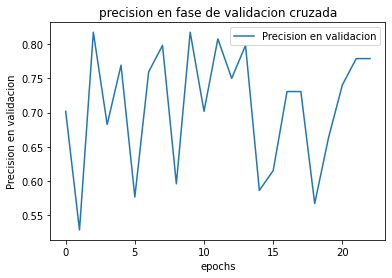

In [35]:
plt.plot(history.history["val_accuracy"])

plt.title("precision en fase de validacion cruzada")
plt.ylabel("Precision en validacion")
plt.xlabel("epochs")
plt.legend(["Precision en validacion"])

In [42]:
test_directory = 'C:\\Users\\wongp\\Udemy\\Data Science Aplicada\\Operaciones\\4. Operations Department\\Test'

In [37]:
os.getcwd()

'C:\\Users\\wongp\\Udemy\\Data Science Aplicada\\Operaciones'

In [41]:
os.listdir('C:\\Users\\wongp\\Udemy\\Data Science Aplicada\\Operaciones\\4. Operations Department\\Test')

['0', '1', '2', '3']

In [43]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40,directory=test_directory,shuffle=True,target_size=(256,256),class_mode="categorical")


Found 40 images belonging to 4 classes.


In [46]:
evaluate = model.evaluate(test_generator, steps=test_generator.n // 4, verbose=1)
print("precision en la fase de test: {}".format(evaluate[1]))

10/10 [==============================] - 3s 2ms/step - loss: 1.4675 - accuracy: 0.7000
precision en la fase de test: 0.699999988079071


In [51]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
prediction=[]
original =[]
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 109ms/step


In [52]:
len(original)

40

In [53]:
score = accuracy_score(original,prediction)
print("Eficacia de la predicción {}".format(score))

Eficacia de la predicción 0.7


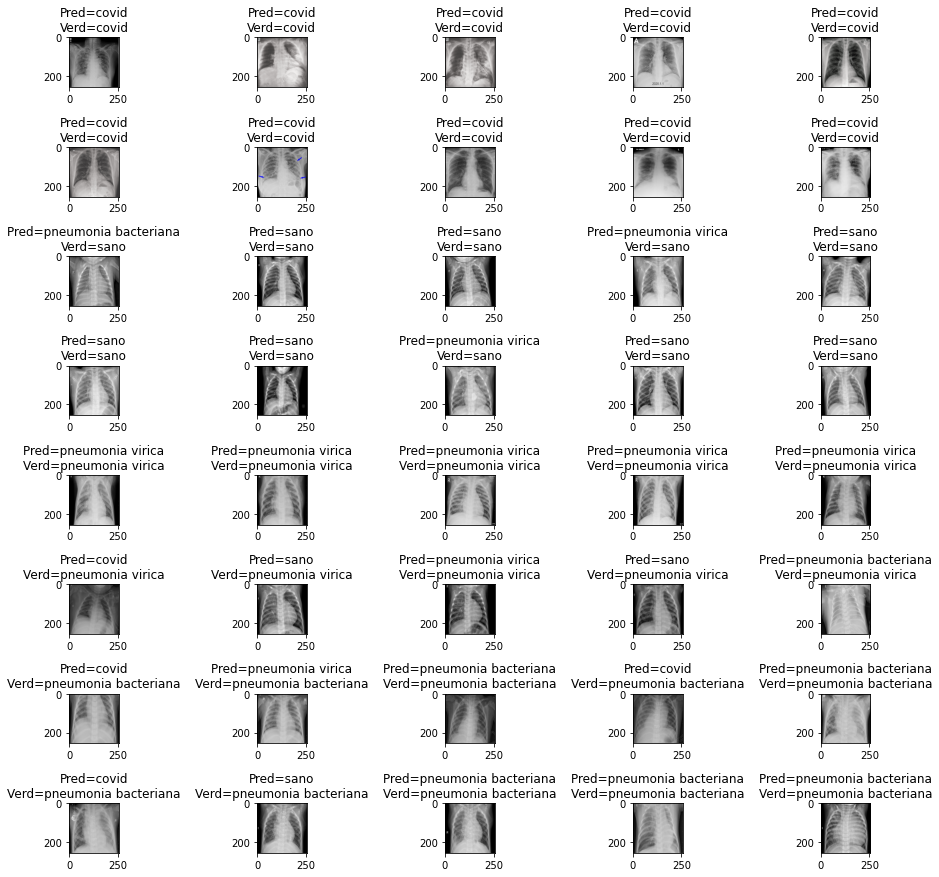

In [63]:
L=8
W=5

fig, axes = plt.subplots(L,W, figsize=(15,15))
axes=axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(labels_names[prediction[i]]),str(labels_names[original[i]])))
    #axes[i].axis('off')

    plt.subplots_adjust(wspace = 1.2, hspace=1.2)

In [65]:
print(classification_report(np.asarray(original),np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.70      0.70      0.70        10
           2       0.67      0.60      0.63        10
           3       0.71      0.50      0.59        10

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.69        40
weighted avg       0.70      0.70      0.69        40



Text(0.5, 1.0, 'Matriz de Confusión')

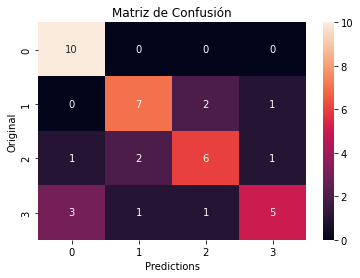

In [72]:
cm = confusion_matrix(np.asarray(original),np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm,annot=True, ax=ax)
ax.set_xlabel("Predictions")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusión")